# Homework 4: Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Information Health Engineering, 2019-2020*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

The aim of this homework is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). 

The problem is the prediction of both the heating load (HL) and cooling load (CL) of residential buildings. We consider eight input variables for each building: relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution.

In this [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) you can find a detailed description of the problem and a solution based on linear regression [(iteratively reweighted least squares (IRLS) algorithm)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwjZuoLY2OjgAhUs3uAKHUZ7BVcQFjAJegQIAhAC&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F9b92%2F18e7233f4d0b491e1582c893c9a099470a73.pdf&usg=AOvVaw3YDwqZh1xyF626VqfnCM2k) and random forests. Using GPs, our goal is not only estimate accurately both HL and CL, but also get a measure of uncertainty in our predictions.

The data set can be downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#).

### 1. Loading and preparing the data

* Download the dataset
* Divide at random the dataset into train (80%) and test (20%) datasets 
* Normalize data if needed

In [1]:
import pandas as pd
import GPy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import the data from the website
data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')

In [3]:
print('The data looks like:')
data.head()

The data looks like:


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
empty = data.apply(lambda col: pd.isnull(col)).sum()
print(empty) # check whether there are missing values

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


In [5]:
# Check how many data points we have
print('There are %d data samples' %data.shape[0])

There are 768 data samples


In [6]:
X = data.iloc[:,0:8]

Y = data.iloc[:,8:10]

feature_names = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area',
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing Area',
    'X8': 'Glazing Area Distribution' }

In [7]:
# Split and normalize the data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # split the data

# split target between HL and CL
HL_train = Y_train[['Y1']].to_numpy().reshape(-1,1)
CL_train = Y_train[['Y2']].to_numpy().reshape(-1,1)
HL_test = Y_test[['Y1']].to_numpy().reshape(-1,1)
CL_test = Y_test[['Y2']].to_numpy().reshape(-1,1)

from sklearn.preprocessing import StandardScaler
transformer = StandardScaler() 
transformer.fit(X_train) # fit the transformer
X_train_norm = transformer.transform(X_train) # transform
X_test_norm =  transformer.transform(X_test) 
X_train_norm = pd.DataFrame(X_train_norm,index=X_train.index, columns=X_train.columns) # reconvert to DataFrames
X_test_norm = pd.DataFrame(X_test_norm,index=X_test.index, columns=X_test.columns)

### 2. Setting and optimizing the model

You will train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs ...

**On the training data set:**

a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term. 

b) Fit the covariance function parameters and noise variance. 

c) According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) 

**On the test data set:**

d) Compute the test mean absolute error error and the test mean square error (MSE)  using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X).


2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this [link](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) you can see how to define different kernels and combine  them. Comments the results. 



## Heating Load GP

In [8]:
n_features = 8
kernelHL = GPy.kern.RBF(n_features,variance=1.0, lengthscale=1.0, ARD=True) + GPy.kern.White(n_features)
mHL = GPy.models.GPRegression(X_train_norm, HL_train, kernelHL)
mHL.optimize_restarts(num_restarts = 10)


# trains faster, but yields incorrect results (much higher MAE and MSE)
# mHL2 = GPy.models.GPRegression(X_train_norm, Y_train[['Y1']], kernelHL2)

Optimization restart 1/10, f = 529.3901256938204
Optimization restart 2/10, f = 535.3660192288098
Optimization restart 3/10, f = 843.3234082987558
Optimization restart 4/10, f = 529.360752618873
Optimization restart 5/10, f = 531.7394473185122
Optimization restart 6/10, f = 530.0323863561139
Optimization restart 7/10, f = 552.908168664276
Optimization restart 8/10, f = 615.4907074547866


 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 9/10, f = 733.0163299900909


 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 10/10, f = 534.6219618573489


In [127]:
display(mHL)
print('RBF lengthscales: ',kernelHL.rbf.lengthscale.values)

idx_HL = np.argsort(kernelHL.rbf.lengthscale.values) + 1 # add 1 so that indices correspond to X1...X8
print('Features ordered by relevance: ',idx_HL)

GP_regression.,value,constraints,priors
sum.rbf.variance,1265.8830547478121,+ve,
sum.rbf.lengthscale,"(8,)",+ve,
sum.white.variance,0.19514644214306373,+ve,
Gaussian_noise.variance,4.635613902633039e-50,+ve,


RBF lengthscales:  [  1.21221362   1.01569334   3.23674854 897.08557937  57.00087926
 737.85049464   2.90302259 196.50623025]
Features ordered by relevance:  [2 1 7 3 5 8 6 4]


In [10]:
meanHLtest,_ = mHL.predict(X_test_norm.to_numpy().reshape(-1,n_features))
from sklearn.metrics import mean_absolute_error , mean_squared_error
MAE_HL = mean_absolute_error(HL_test,meanHLtest)
MSE_HL = mean_squared_error(HL_test,meanHLtest)
print('MAE is %.2f and MSE is %.2f' %(MAE_HL,MSE_HL))

MAE is 0.36 and MSE is 0.23


#### Visualizing the results
Now, let's visualize the results of the GP fitting, both with the 95% confidence interval and by taking samples from the GP. As the data is multidimensional and it can not be visualized directly, we must choose one X dimension to plot. The most relevant feature (lower lengthscale) will be used.

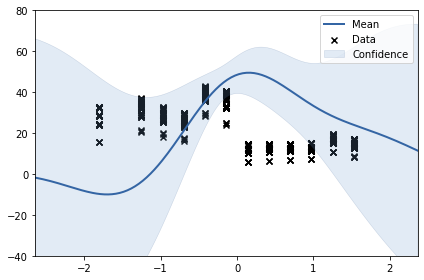

In [125]:
# plot the results HL vs most relevant feature, and the 95% confidence interval
x_dim = idx_HL[0]-1
fig = mHL.plot(visible_dims=[x_dim])#, plot_density=True)
plt.ylim((-40,80))
plt.show()
# mHL.plot_confidence(visible_dims=[x_dim])

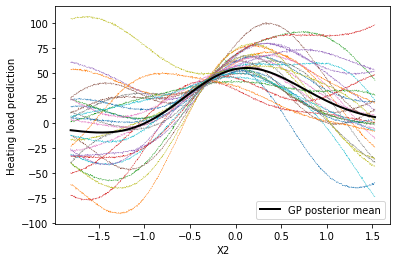

In [100]:
# sample from the GP and plot
X_true = np.zeros((1000,n_features))
for i in range(n_features):
    m = np.min(X_train_norm.iloc[:,i])
    M = np.max(X_train_norm.iloc[:,i])
    X_true[:,i:i+1] = np.linspace(m,M,1000)[:,None]

n_samples = 30
posteriorYtest = mHL.posterior_samples_f(X_true, full_cov=True, size=n_samples)
meanYtest,_ = mHL.predict(X_true,full_cov=True)

plt.figure()
plt.plot(X_true[:,x_dim],posteriorYtest.reshape([-1,n_samples]),'--',lw=0.5,)
plt.plot(X_true[:,x_dim],meanYtest,'k',label='GP posterior mean',lw=2)
plt.legend()
plt.xlabel('X'+str(x_dim+1))
plt.ylabel('Heating load prediction')
plt.show()

## Cooling Load

In [11]:
n_features = 8
kernelCL = GPy.kern.RBF(n_features, ARD=True) + GPy.kern.White(n_features)
mCL = GPy.models.GPRegression(X_train_norm, CL_train, kernelCL)
mCL.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 1236.3146225202556
Optimization restart 2/10, f = 1236.7045621141747
Optimization restart 3/10, f = 1310.2568772217853
Optimization restart 4/10, f = 1236.5219278880772
Optimization restart 5/10, f = 1239.4228498354364
Optimization restart 6/10, f = 1264.102021816645
Optimization restart 7/10, f = 1454.48558523907
Optimization restart 8/10, f = 1623.1295685866774
Optimization restart 9/10, f = 1238.9288115957406
Optimization restart 10/10, f = 1240.0138121099678


In [16]:
display(mCL)
# print('RBF variance: ', kernelCL.rbf.variance.values)
print('RBF lengthscales: ',kernelCL.rbf.lengthscale.values)
# print('White noise variance: ',kernelCL.white.variance.values)

idx_CL = np.argsort(kernelCL.rbf.lengthscale.values) + 1 # add 1 so that indices correspond to X1...X8
print('Features ordered by relevance: ',idx_CL)

GP_regression.,value,constraints,priors
sum.rbf.variance,609.678620717389,+ve,
sum.rbf.lengthscale,"(8,)",+ve,
sum.white.variance,1.331129477894194,+ve,
Gaussian_noise.variance,1.331129477894194,+ve,


RBF lengthscales:  [1.96950549e+00 3.21024855e+00 1.10099426e+00 1.48417503e+02
 2.17571896e+02 4.08546805e+02 1.06918735e+01 1.32036883e+03]
Features ordered by relevance:  [3 1 2 7 4 5 6 8]


In [17]:
meanCLtest,CLcov = mCL.predict(X_test_norm.to_numpy().reshape(-1,n_features))
MAE_CL = mean_absolute_error(CL_test,meanCLtest)
MSE_CL = mean_squared_error(CL_test,meanCLtest)
print('MAE is %.2f and MSE is %.2f' %(MAE_CL,MSE_CL))

MAE is 1.19 and MSE is 2.97


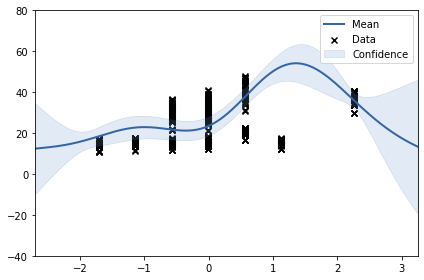

In [126]:
# plot the results CL vs most relevant feature, and the 95% confidence interval
x_dim = idx_CL[0]-1
fig = mCL.plot(visible_dims=[x_dim])
plt.ylim((-40,80))
plt.show()

## Different kernels for cooling load
*Although having narrower confidence intervals than the GP for heating load, the MSE for cooling load is much higher. The possible explanation is that the provided kernel is not able to appropiately model the data. Therefore, let's try other kernels for the cooling load problem.*

In [132]:
def try_kernel(kernel):
    n_features = 8
#     k = GPy.kern.Linear(n_features) + GPy.kern.White(n_features)
    m = GPy.models.GPRegression(X_train_norm, CL_train, k)
    m.optimize_restarts(num_restarts = 10)
    display(m)
    meantest,_ = m.predict(X_test_norm.to_numpy().reshape(-1,n_features))
    MAE = mean_absolute_error(CL_test,meantest)
    MSE = mean_squared_error(CL_test,meantest)
    print('MAE is %.2f and MSE is %.2f' %(MAE,MSE))
    return MAE,MSE

In [136]:
k1 = GPy.kern.Matern52(n_features) + GPy.kern.White(n_features)
try_kernel(k1)

 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 1236.2795530672063
Optimization restart 2/10, f = 1236.5633339184017
Optimization restart 3/10, f = 1239.4225651217835
Optimization restart 4/10, f = 1238.9295136209005
Optimization restart 5/10, f = 1238.9116435611045
Optimization restart 6/10, f = 1236.650070083248
Optimization restart 7/10, f = 1239.3273940019235
Optimization restart 8/10, f = 1241.2901174302674
Optimization restart 9/10, f = 1238.7369225857049
Optimization restart 10/10, f = 1240.2946911325475


GP_regression.,value,constraints,priors
sum.rbf.variance,619.2047317509175,+ve,
sum.rbf.lengthscale,"(8,)",+ve,
sum.white.variance,8.873842268130697e-24,+ve,
Gaussian_noise.variance,2.6612551453061166,+ve,


MAE is 1.19 and MSE is 2.97


(1.186129095877438, 2.9705481603006003)

In [135]:
try_kernel(kernelCL)

 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 1237.414470011303
Optimization restart 2/10, f = 1236.2935124700991
Optimization restart 3/10, f = 1237.4055065025898


 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/10, f = 1406.6543964149078
Optimization restart 5/10, f = 1238.9288133352154


 C:\Users\Equipo\Anaconda3\envs\py37\lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 6/10, f = 1240.188440873617
Optimization restart 7/10, f = 1238.9288568587228
Optimization restart 8/10, f = 1236.489201383128
Optimization restart 9/10, f = 1236.2833297064983
Optimization restart 10/10, f = 1236.279542654935


GP_regression.,value,constraints,priors
sum.rbf.variance,619.2046843975875,+ve,
sum.rbf.lengthscale,"(8,)",+ve,
sum.white.variance,8.873842268130697e-24,+ve,
Gaussian_noise.variance,2.661251703753035,+ve,


MAE is 1.19 and MSE is 2.97


(1.186142796968483, 2.97060443229521)

In [128]:
n_features = 8
k1 = GPy.kern.Matern52(n_features) + GPy.kern.White(n_features)
m1 = GPy.models.GPRegression(X_train_norm, CL_train, k1)
m1.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 1352.3154748328227
Optimization restart 2/10, f = 1352.3154748332195
Optimization restart 3/10, f = 1352.3093641730945
Optimization restart 4/10, f = 1325.367252428092
Optimization restart 5/10, f = 1325.36725242592
Optimization restart 6/10, f = 1352.3154748390812
Optimization restart 7/10, f = 1352.3154752069277
Optimization restart 8/10, f = 1352.3154748330167
Optimization restart 9/10, f = 1352.3154748362429
Optimization restart 10/10, f = 1352.3154373639427


In [129]:
display(m1)
meantest,_ = m1.predict(X_test_norm.to_numpy().reshape(-1,n_features))
MAE1 = mean_absolute_error(CL_test,meantest)
MSE1 = mean_squared_error(CL_test,meantest)
print('MAE is %.2f and MSE is %.2f' %(MAE1,MSE1))

GP_regression.,value,constraints,priors
sum.Mat52.variance,4481.856053900731,+ve,
sum.Mat52.lengthscale,5.591662235323929,+ve,
sum.white.variance,5.562684646268137e-309,+ve,
Gaussian_noise.variance,0.5151069729721895,+ve,


MAE is 0.77 and MSE is 1.44


# Results on paper "Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools"
In the paper published by A. Tsanas and A. Xifara on 2012 (where this data comes from), the following results were obtained:

* Random forest (RF) largely outperforms iterative reweighted least squares (IRLS). All the following reported results will be the ones for RF.
* According to their results (100 repetitions of 10-fold CV), the importance of the input variables for predicting HL is $X7 > X1 > X2 > X3 > X8 > X4 > X6 > X5$. And the achieved errors are MAE = 0.51 +- 0.11 and MSE = 1.03+-0.54.
* And for CL prediction, the importance of the input variables is $X7 > X1 > X2 > X8 > X3 > X6 > X4 > X5$, and the achieved errors are MAE = 1.42+-0.25 and MSE = 6.59 +- 1.56.


In [14]:
print('HL prediction:')
print('Most important features: ',idx_HL)
print('MAE = %.2f and MSE = %.2f' %(MAE_HL,MSE_HL))

print('\nCL prediction:')
print('Most important features: ',idx_CL)
print('MAE = %.2f and MSE = %.2f' %(MAE_CL,MSE_CL))

HL prediction:
Most important features:  [2 1 7 3 5 8 6 4]
MAE = 0.36 and MSE = 0.23

CL prediction:
Most important features:  [3 1 2 7 4 5 6 8]
MAE = 1.19 and MSE = 2.97


*We can see how using GPs strongly outperforms RF in this problem, achieving substantially lower errors.*

*The order in which these GPs rank the features slightly varies between different executions. Nevertheless, it is more or less consistent, always placing features X1, X2, X3 and X7 among the most useful features, and X4, X5, X6 and X8 as the less useful.*

### Sparse GP implementation 

Try to implement an sparse version of the GP regressor, optimized to find a set of **inducing points** that the GP relies on to do the prediction. Measure the test error prediction for 20, 40, and 100 inducing points. 

In [15]:
#Your code here